In [ ]:
# In this file, trying lightGBM with cross validation
# try the package in scikit-learn too
# single thread

# lgb document: http://lightgbm.readthedocs.io/en/latest/python/lightgbm.html#lightgbm-package
# xgb document: http://xgboost.readthedocs.io/en/latest/python/python_api.html

# LightGBM scikit-learn API: http://lightgbm.readthedocs.io/en/latest/python/lightgbm.html#scikit-learn-api
# XGBoost scikit-learn API: http://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn
# both scikit-learn lightGBM, Xgboost provide regressor and classifier

In [13]:
import numpy as np 
import pandas as pd 
from pandas import Series, DataFrame 
import lightgbm as lgb 
import xgboost as xgb 
from datetime import datetime 
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split 

from lightgbm.sklearn import LGBMClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.grid_search import GridSearchCV 
from xgboost import plot_importance
from lightgbm import plot_importance as lgb_plot_importance
%matplotlib inline

In [2]:
data=pd.read_csv('adult.csv',header=None) 
# assign column names to the data
data.columns=['age','workclass','fnlwgt','education','education-num','marital_Status','occupation','relationship','race','sex','capital_gain','capital_loss','hours_per_week','native_country','Income'] 
data.head()

,age,workclass,fnlwgt,education,education-num,marital_Status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,Income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
# data preprocessing

## encode label
l=LabelEncoder() 
l.fit(data.Income) 
l.classes_ 
data.Income=Series(l.transform(data.Income))
data.Income.value_counts()

0    24720
1     7841
Name: Income, dtype: int64

In [4]:
## convert categorical data into one-hot, and drop original categorical data
one_hot_workclass=pd.get_dummies(data.workclass) 
one_hot_education=pd.get_dummies(data.education) 
one_hot_marital_Status=pd.get_dummies(data.marital_Status) 
one_hot_occupation=pd.get_dummies(data.occupation)
one_hot_relationship=pd.get_dummies(data.relationship) 
one_hot_race=pd.get_dummies(data.race) 
one_hot_sex=pd.get_dummies(data.sex) 
one_hot_native_country=pd.get_dummies(data.native_country) 

data.drop(['workclass','education','marital_Status','occupation','relationship','race','sex','native_country'],axis=1,inplace=True) 

In [5]:
data=pd.concat([data,one_hot_workclass,one_hot_education,one_hot_marital_Status,one_hot_occupation,one_hot_relationship,one_hot_race,one_hot_sex,one_hot_native_country],axis=1) 
## remove dulpicate columns 
i = np.unique(data.columns, return_index=True) 
data=data.iloc[:, i[1]]  # use the index of unique columns
data.head()

,10th,11th,12th,1st-4th,5th-6th,7th-8th,9th,?,Adm-clerical,Amer-Indian-Eskimo,...,Wife,Without-pay,Yugoslavia,Income,age,capital_gain,capital_loss,education-num,fnlwgt,hours_per_week
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,39,2174,0,13,77516,40
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,50,0,0,13,83311,13
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,38,0,0,9,215646,40
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,53,0,0,7,234721,40
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,28,0,0,13,338409,40


In [6]:
features = data.drop('Income',axis=1) 
label = data.Income

In [7]:
label.mode()[0]
label.fillna(label.mode()[0],inplace=True)  # impute missing data with mode

In [8]:
label.value_counts()

0    24720
1     7841
Name: Income, dtype: int64

In [9]:
features_train,features_test,label_train,label_test=train_test_split(features,label,test_size=.3)

In [95]:
# method 1 - xgboost, with cross validation

dtrain=xgb.DMatrix(features_train,label=label_train)
dtest=xgb.DMatrix(features_test)
## booster params
booster_params = {'max_depth':7, 'eta':1, 'silent':1,'objective':'binary:logistic','eval_metric':'auc','learning_rate':.05}

In [49]:
num_boost_round = 50
nfold = 5
metrics = ('auc', 'logloss')
seed = 410

xgb_cv = xgb.cv(booster_params, dtrain, num_boost_round, nfold, metrics, seed)
print(xgb_cv.shape)

(50, 4)


In [48]:
xgb_cv   # it returns the optimum number of trees required (n_estimators)

,test-auc-mean,test-auc-std,train-auc-mean,train-auc-std
0,0.850824,0.003935,0.859200,0.001329
1,0.852598,0.003079,0.861530,0.001734
2,0.853106,0.003554,0.862625,0.001434
3,0.854285,0.004212,0.863689,0.001647
4,0.855042,0.004495,0.864591,0.000981
5,0.855559,0.004038,0.865549,0.000874
6,0.856063,0.003676,0.866360,0.001218
7,0.856301,0.003618,0.866771,0.001364
8,0.856692,0.003609,0.867315,0.001473
9,0.857321,0.003379,0.867708,0.001699


In [92]:
# CV method 1 - xgboost cv() method

def modelfit(alg, dtrain, predictors, useTrainCV=True, cv_folds=10, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = dtrain
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics=('auc'), early_stopping_rounds=early_stopping_rounds, seed = 410)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg_fit = alg.fit(features_train, label_train, eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(features_train)
    dtrain_predprob = alg.predict_proba(features_train)[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % accuracy_score(label_train, dtrain_predictions))
    print("AUC Score (Train): %f" % roc_auc_score(label_train, dtrain_predprob))
                    
    plot_importance(alg_fit, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance', xlabel='F score', ylabel='Features', importance_type='weight', max_num_features=7, grid=True,)
    
    return alg_fit


Model Report
Accuracy : 0.8522
AUC Score (Train): 0.894681
0:00:20.832283


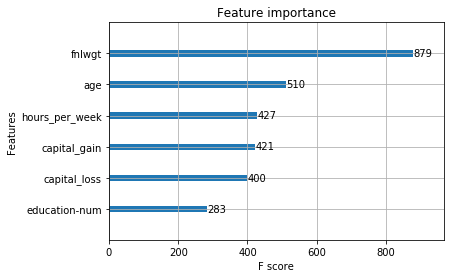

In [93]:
start=datetime.now()

xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,  # default value here, will be changed by cvresult
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=410)
xgb_model = modelfit(xgb1, dtrain, features_train)

stop=datetime.now()
execution_time_lgbm = stop-start
print(execution_time_lgbm)  # 0:00:20.234687

In [99]:
ypred = xgb_model.predict(features_test) 
print(ypred)

[0 0 0 ..., 0 1 0]


In [102]:
accuracy_xgb = accuracy_score(label_test,ypred) 
print("sklearn accuracy", accuracy_xgb)

cm = confusion_matrix(label_test, ypred)
TP = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TN = cm[1][1]

accuracy_xgb = (TP + TN)/(TP+FP+FN+TN)   
auc_score_xgb = roc_auc_score(label_test, ypred)   
precision_xgb = TP/(TP+FP)  
specificity_xgb = TN/(TN+FP) 
recall_xgb = TP/(TP+FN)   
print("accuracy: ", accuracy_xgb)
print("AUC: ", auc_score_xgb)
print("Precision: ", precision_xgb)
print("Specificity: ", specificity_xgb)
print("Recall: ", recall_xgb)

sklearn accuracy 0.847476712048
accuracy:  0.847476712048
AUC:  0.722712689445
Precision:  0.957236402512
Specificity:  0.777158774373
Recall:  0.859594383775


In [109]:
# CV method 2 - GridSearchCV() method
## GridSearchCV params: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

param_set = {
 'max_depth':[3,5,7,9],
 'min_child_weight':[1,3,5]  # smaller min_child_weight can handle smaller class in inbalanced dataset
}
gsearch = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=100, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=7,
 objective= 'binary:logistic', scale_pos_weight=1, seed=410), 
 param_grid = param_set, scoring='roc_auc',n_jobs=7,iid=False, cv=10)

In [110]:
xgb_model2 = gsearch.fit(features_train, label_train)
xgb_model2.grid_scores_, xgb_model2.best_params_, xgb_model2.best_score_

([mean: 0.86903, std: 0.00681, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.86902, std: 0.00695, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.86865, std: 0.00690, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.87415, std: 0.00686, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.87371, std: 0.00721, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.87281, std: 0.00723, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.87421, std: 0.00724, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.87388, std: 0.00693, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.87271, std: 0.00696, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.87298, std: 0.00649, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.87169, std: 0.00657, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.87116, std: 0.00658, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 7, 'min_child_weight': 1

In [111]:
# modify values with optimum values and tune other params

param_set = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=100, max_depth=7,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=7,
 objective= 'binary:logistic', scale_pos_weight=1, seed=410), 
 param_grid = param_set, scoring='roc_auc',n_jobs=7,iid=False, cv=10)

xgb_model2 = gsearch.fit(features_train, label_train)
xgb_model2.grid_scores_, xgb_model2.best_params_, xgb_model2.best_score_

([mean: 0.87421, std: 0.00724, params: {'gamma': 0.0},
  mean: 0.87483, std: 0.00685, params: {'gamma': 0.1},
  mean: 0.87472, std: 0.00677, params: {'gamma': 0.2},
  mean: 0.87498, std: 0.00677, params: {'gamma': 0.3},
  mean: 0.87459, std: 0.00688, params: {'gamma': 0.4}],
 {'gamma': 0.3},
 0.8749824643981604)

In [112]:
# modify values with optimum values and tune other params

param_set = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=100, max_depth=7,
 min_child_weight=1, gamma=0.3, subsample=0.8, colsample_bytree=0.8, nthread=7,
 objective= 'binary:logistic', scale_pos_weight=1, seed=410), 
 param_grid = param_set, scoring='roc_auc',n_jobs=7,iid=False, cv=10)

xgb_model2 = gsearch.fit(features_train, label_train)
xgb_model2.grid_scores_, xgb_model2.best_params_, xgb_model2.best_score_

([mean: 0.87401, std: 0.00714, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: 0.87436, std: 0.00757, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: 0.87529, std: 0.00698, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: 0.87563, std: 0.00686, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
  mean: 0.87269, std: 0.00743, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
  mean: 0.87321, std: 0.00703, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
  mean: 0.87498, std: 0.00677, params: {'colsample_bytree': 0.7, 'subsample': 0.8},
  mean: 0.87539, std: 0.00634, params: {'colsample_bytree': 0.7, 'subsample': 0.9},
  mean: 0.87269, std: 0.00743, params: {'colsample_bytree': 0.8, 'subsample': 0.6},
  mean: 0.87321, std: 0.00703, params: {'colsample_bytree': 0.8, 'subsample': 0.7},
  mean: 0.87498, std: 0.00677, params: {'colsample_bytree': 0.8, 'subsample': 0.8},
  mean: 0.87539, std: 0.00634, params: {'colsample_bytree': 0.8, 'subsample'

In [113]:
# subsample and colsample_bytree are choosing edge values, check in more detail

param_set = {
 'subsample':[0.8, 0.9, 1.0],
 'colsample_bytree':[i/10.0 for i in range(1,7)]
}
gsearch = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=100, max_depth=7,
 min_child_weight=1, gamma=0.3, subsample=0.8, colsample_bytree=0.8, nthread=7,
 objective= 'binary:logistic', scale_pos_weight=1, seed=410), 
 param_grid = param_set, scoring='roc_auc',n_jobs=7,iid=False, cv=10)

xgb_model2 = gsearch.fit(features_train, label_train)
xgb_model2.grid_scores_, xgb_model2.best_params_, xgb_model2.best_score_

([mean: 0.87571, std: 0.00650, params: {'colsample_bytree': 0.1, 'subsample': 0.8},
  mean: 0.87618, std: 0.00708, params: {'colsample_bytree': 0.1, 'subsample': 0.9},
  mean: 0.87641, std: 0.00686, params: {'colsample_bytree': 0.1, 'subsample': 1.0},
  mean: 0.87571, std: 0.00650, params: {'colsample_bytree': 0.2, 'subsample': 0.8},
  mean: 0.87618, std: 0.00708, params: {'colsample_bytree': 0.2, 'subsample': 0.9},
  mean: 0.87641, std: 0.00686, params: {'colsample_bytree': 0.2, 'subsample': 1.0},
  mean: 0.87571, std: 0.00650, params: {'colsample_bytree': 0.3, 'subsample': 0.8},
  mean: 0.87618, std: 0.00708, params: {'colsample_bytree': 0.3, 'subsample': 0.9},
  mean: 0.87641, std: 0.00686, params: {'colsample_bytree': 0.3, 'subsample': 1.0},
  mean: 0.87595, std: 0.00658, params: {'colsample_bytree': 0.4, 'subsample': 0.8},
  mean: 0.87595, std: 0.00696, params: {'colsample_bytree': 0.4, 'subsample': 0.9},
  mean: 0.87584, std: 0.00704, params: {'colsample_bytree': 0.4, 'subsample'

In [119]:
# subsample and colsample_bytree are choosing edge

param_set = {
 'subsample':[0.8, 0.9, 1.0],
 'colsample_bytree':[i/100.0 for i in range(1,10,2)]
}
gsearch = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=100, max_depth=7,
 min_child_weight=1, gamma=0.3, subsample=0.8, colsample_bytree=0.8, nthread=7,
 objective= 'binary:logistic', scale_pos_weight=1, seed=410), 
 param_grid = param_set, scoring='roc_auc',n_jobs=7,iid=False, cv=10)

xgb_model2 = gsearch.fit(features_train, label_train)
xgb_model2.grid_scores_, xgb_model2.best_params_, xgb_model2.best_score_   # got the same accuracy in fact

([mean: 0.87571, std: 0.00650, params: {'colsample_bytree': 0.01, 'subsample': 0.8},
  mean: 0.87618, std: 0.00708, params: {'colsample_bytree': 0.01, 'subsample': 0.9},
  mean: 0.87641, std: 0.00686, params: {'colsample_bytree': 0.01, 'subsample': 1.0},
  mean: 0.87571, std: 0.00650, params: {'colsample_bytree': 0.03, 'subsample': 0.8},
  mean: 0.87618, std: 0.00708, params: {'colsample_bytree': 0.03, 'subsample': 0.9},
  mean: 0.87641, std: 0.00686, params: {'colsample_bytree': 0.03, 'subsample': 1.0},
  mean: 0.87571, std: 0.00650, params: {'colsample_bytree': 0.05, 'subsample': 0.8},
  mean: 0.87618, std: 0.00708, params: {'colsample_bytree': 0.05, 'subsample': 0.9},
  mean: 0.87641, std: 0.00686, params: {'colsample_bytree': 0.05, 'subsample': 1.0},
  mean: 0.87571, std: 0.00650, params: {'colsample_bytree': 0.07, 'subsample': 0.8},
  mean: 0.87618, std: 0.00708, params: {'colsample_bytree': 0.07, 'subsample': 0.9},
  mean: 0.87641, std: 0.00686, params: {'colsample_bytree': 0.07,


Model Report
Accuracy : 0.8452
AUC Score (Train): 0.888306
0:00:07.113186
[0 0 0 ..., 0 1 0]


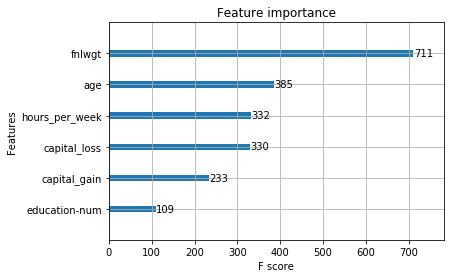

In [120]:
start=datetime.now()

xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=100,
 max_depth=7,
 min_child_weight=1,
 gamma=0.3,
 subsample=1.0,
 colsample_bytree=0.1,
 objective= 'binary:logistic',
 nthread=7,
 scale_pos_weight=1,
 seed=410)
xgb_model2 = modelfit(xgb2, dtrain, features_train)

stop=datetime.now()
execution_time_lgbm = stop-start
print(execution_time_lgbm)      # 0:00:07.11318

ypred = xgb_model2.predict(features_test) 
print(ypred)

In [121]:
ypred2=xgb_model2.predict(features_test)
ypred2[0:5]

array([0, 0, 0, 0, 1])

In [122]:
cm = confusion_matrix(label_test, ypred2)
TP = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TN = cm[1][1]

accuracy_xgb = (TP + TN)/(TP+FP+FN+TN)   
auc_score_xgb = roc_auc_score(label_test, ypred)   
precision_xgb = TP/(TP+FP)   
specificity_xgb = TN/(TN+FP) 
recall_xgb = TP/(TP+FN)
print("accuracy: ", accuracy_xgb)
print("AUC: ", auc_score_xgb)
print("Precision: ", precision_xgb)
print("Specificity: ", specificity_xgb)
print("Recall: ", recall_xgb)

accuracy:  0.848397993653
AUC:  0.709338834984
Precision:  0.970733662969
Specificity:  0.823813354787
Recall:  0.851982172179


In [132]:
# modify values with optimum values and tune other params

param_set = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=100, max_depth=7,
 min_child_weight=1, gamma=0.3, subsample=1.0, colsample_bytree=0.1, nthread=7,
 objective= 'binary:logistic', scale_pos_weight=1, seed=410), 
 param_grid = param_set, scoring='roc_auc',n_jobs=7,iid=False, cv=10)

xgb_model3 = gsearch.fit(features_train, label_train)
xgb_model3.grid_scores_, xgb_model3.best_params_, xgb_model3.best_score_

([mean: 0.87641, std: 0.00686, params: {'reg_alpha': 1e-05},
  mean: 0.87637, std: 0.00690, params: {'reg_alpha': 0.01},
  mean: 0.87621, std: 0.00699, params: {'reg_alpha': 0.1},
  mean: 0.87540, std: 0.00711, params: {'reg_alpha': 1},
  mean: 0.85617, std: 0.00683, params: {'reg_alpha': 100}],
 {'reg_alpha': 1e-05},
 0.8764095331109016)

In [133]:
# further tune reg_alpha value

param_set = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}
gsearch = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=100, max_depth=7,
 min_child_weight=1, gamma=0.3, subsample=1.0, colsample_bytree=0.1, nthread=7,
 objective= 'binary:logistic', scale_pos_weight=1, seed=410), 
 param_grid = param_set, scoring='roc_auc',n_jobs=7,iid=False, cv=10)

xgb_model3 = gsearch.fit(features_train, label_train)
xgb_model3.grid_scores_, xgb_model3.best_params_, xgb_model3.best_score_

([mean: 0.87641, std: 0.00686, params: {'reg_alpha': 0},
  mean: 0.87640, std: 0.00687, params: {'reg_alpha': 0.001},
  mean: 0.87640, std: 0.00688, params: {'reg_alpha': 0.005},
  mean: 0.87637, std: 0.00690, params: {'reg_alpha': 0.01},
  mean: 0.87634, std: 0.00704, params: {'reg_alpha': 0.05}],
 {'reg_alpha': 0},
 0.8764095331109016)


Model Report
Accuracy : 0.8452
AUC Score (Train): 0.888306
0:00:07.100202
[0 0 0 ..., 0 1 0]


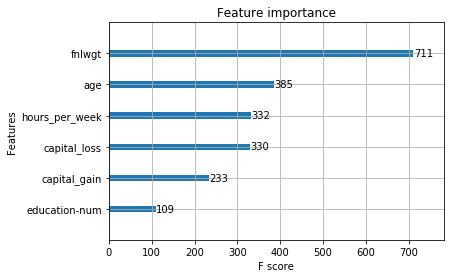

In [130]:
start=datetime.now()

xgb3 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=100,
 max_depth=7,
 min_child_weight=1,
 gamma=0.3,
 subsample=1.0,
 colsample_bytree=0.1,
 objective= 'binary:logistic',
 nthread=7,
 scale_pos_weight=1,
 reg_alpha = 0,
 seed=410)
xgb_model3 = modelfit(xgb3, dtrain, features_train)

stop=datetime.now()
execution_time_lgbm = stop-start
print(execution_time_lgbm)      # 0:00:07.100202

ypred = xgb_model3.predict(features_test) 
print(ypred)

In [131]:
ypred3=xgb_model3.predict(features_test)

cm = confusion_matrix(label_test, ypred3)
TP = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TN = cm[1][1]

accuracy_xgb = (TP + TN)/(TP+FP+FN+TN)  
auc_score_xgb = roc_auc_score(label_test, ypred)   
precision_xgb = TP/(TP+FP)  
specificity_xgb = TN/(TN+FP)  
recall_xgb = TP/(TP+FN)   
print("accuracy: ", accuracy_xgb)
print("AUC: ", auc_score_xgb)
print("Precision: ", precision_xgb)
print("Specificity: ", specificity_xgb)
print("Recall: ", recall_xgb)

accuracy:  0.848397993653
AUC:  0.709338834984
Precision:  0.970733662969
Specificity:  0.823813354787
Recall:  0.851982172179


In [134]:
# tune scale_pos_weight
## A value greater than 0 should be used in case of high class imbalance as it helps in faster convergence.

# tune learning rate

param_set = {
 'scale_pos_weight':[i/10.0 for i in range(11)]
}
gsearch = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=100, max_depth=7,
 min_child_weight=1, gamma=0, subsample=1.0, colsample_bytree=0.1, nthread=7,
 objective= 'binary:logistic', scale_pos_weight=1, seed=410), 
 param_grid = param_set, scoring='roc_auc',n_jobs=7,iid=False, cv=10)

xgb_model4 = gsearch.fit(features_train, label_train)
xgb_model4.grid_scores_, xgb_model4.best_params_, xgb_model4.best_score_

([mean: 0.50000, std: 0.00000, params: {'scale_pos_weight': 0.0},
  mean: 0.87003, std: 0.00723, params: {'scale_pos_weight': 0.1},
  mean: 0.87276, std: 0.00751, params: {'scale_pos_weight': 0.2},
  mean: 0.87382, std: 0.00722, params: {'scale_pos_weight': 0.3},
  mean: 0.87469, std: 0.00704, params: {'scale_pos_weight': 0.4},
  mean: 0.87489, std: 0.00709, params: {'scale_pos_weight': 0.5},
  mean: 0.87513, std: 0.00694, params: {'scale_pos_weight': 0.6},
  mean: 0.87550, std: 0.00716, params: {'scale_pos_weight': 0.7},
  mean: 0.87567, std: 0.00707, params: {'scale_pos_weight': 0.8},
  mean: 0.87593, std: 0.00715, params: {'scale_pos_weight': 0.9},
  mean: 0.87625, std: 0.00704, params: {'scale_pos_weight': 1.0}],
 {'scale_pos_weight': 1.0},
 0.8762515651925522)

In [135]:
# tune learning rate

param_set = {
 'learning_rate':[0.01, 0.05, 0.1]
}
gsearch = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=100, max_depth=7,
 min_child_weight=1, gamma=0, subsample=1.0, colsample_bytree=0.1, nthread=7,
 objective= 'binary:logistic', scale_pos_weight=1, seed=410), 
 param_grid = param_set, scoring='roc_auc',n_jobs=7,iid=False, cv=10)

xgb_model4 = gsearch.fit(features_train, label_train)
xgb_model4.grid_scores_, xgb_model4.best_params_, xgb_model4.best_score_

([mean: 0.86927, std: 0.00658, params: {'learning_rate': 0.01},
  mean: 0.87395, std: 0.00670, params: {'learning_rate': 0.05},
  mean: 0.87625, std: 0.00704, params: {'learning_rate': 0.1}],
 {'learning_rate': 0.1},
 0.8762515651925522)

In [136]:
# tune learning rate

param_set = {
 'learning_rate':[i/10.0 for i in range(1,10)]
}
gsearch = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=100, max_depth=7,
 min_child_weight=1, gamma=0, subsample=1.0, colsample_bytree=0.1, nthread=7,
 objective= 'binary:logistic', scale_pos_weight=1, seed=410), 
 param_grid = param_set, scoring='roc_auc',n_jobs=7,iid=False, cv=10)

xgb_model4 = gsearch.fit(features_train, label_train)
xgb_model4.grid_scores_, xgb_model4.best_params_, xgb_model4.best_score_

([mean: 0.87625, std: 0.00704, params: {'learning_rate': 0.1},
  mean: 0.87670, std: 0.00762, params: {'learning_rate': 0.2},
  mean: 0.87644, std: 0.00762, params: {'learning_rate': 0.3},
  mean: 0.87536, std: 0.00778, params: {'learning_rate': 0.4},
  mean: 0.87513, std: 0.00757, params: {'learning_rate': 0.5},
  mean: 0.87383, std: 0.00772, params: {'learning_rate': 0.6},
  mean: 0.87317, std: 0.00747, params: {'learning_rate': 0.7},
  mean: 0.87159, std: 0.00714, params: {'learning_rate': 0.8},
  mean: 0.87002, std: 0.00823, params: {'learning_rate': 0.9}],
 {'learning_rate': 0.2},
 0.8766982733341692)

In [137]:
# tune n_estimators

param_set = {
 'n_estimators':[50, 100, 500, 1000]
}
gsearch = GridSearchCV(estimator = XGBClassifier(learning_rate =0.2, n_estimators=100, max_depth=7,
 min_child_weight=1, gamma=0, subsample=1.0, colsample_bytree=0.1, nthread=7,
 objective= 'binary:logistic', scale_pos_weight=1, seed=410), 
 param_grid = param_set, scoring='roc_auc',n_jobs=7,iid=False, cv=10)

xgb_model4 = gsearch.fit(features_train, label_train)
xgb_model4.grid_scores_, xgb_model4.best_params_, xgb_model4.best_score_

([mean: 0.87494, std: 0.00658, params: {'n_estimators': 50},
  mean: 0.87670, std: 0.00762, params: {'n_estimators': 100},
  mean: 0.87334, std: 0.00810, params: {'n_estimators': 500},
  mean: 0.87127, std: 0.00784, params: {'n_estimators': 1000}],
 {'n_estimators': 100},
 0.8766982733341692)


Model Report
Accuracy : 0.8499
AUC Score (Train): 0.893772
0:00:07.033940
[0 0 0 ..., 0 1 0]


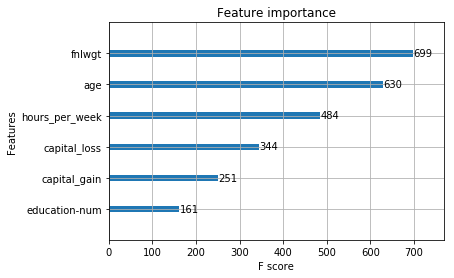

In [138]:
start=datetime.now()

xgb4 = XGBClassifier(
 learning_rate =0.2,
 n_estimators=100,
 max_depth=7,
 min_child_weight=1,
 gamma=0,
 subsample=1.0,
 colsample_bytree=0.1,
 objective= 'binary:logistic',
 nthread=7,
 scale_pos_weight=1,
 reg_alpha = 0,
 seed=410)
xgb_model4 = modelfit(xgb4, dtrain, features_train)

stop=datetime.now()
execution_time_lgbm = stop-start
print(execution_time_lgbm)      # 0:00:07.033940

ypred = xgb_model4.predict(features_test) 
print(ypred)

In [139]:
ypred4=xgb_model4.predict(features_test)

cm = confusion_matrix(label_test, ypred4)
TP = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TN = cm[1][1]

accuracy_xgb = (TP + TN)/(TP+FP+FN+TN)  
auc_score_xgb = roc_auc_score(label_test, ypred) 
precision_xgb = TP/(TP+FP)   
specificity_xgb = TN/(TN+FP)  
recall_xgb = TP/(TP+FN)  
print("accuracy: ", accuracy_xgb)
print("AUC: ", auc_score_xgb)
print("Precision: ", precision_xgb)
print("Specificity: ", specificity_xgb)
print("Recall: ", recall_xgb)

# both precision and specificity dropped, while accuracy, AUC, recall increased

accuracy:  0.848807452145
AUC:  0.721758470556
Precision:  0.960577308566
Specificity:  0.789135096497
Recall:  0.858781362007


In [146]:
# LightGBM Cross Validation method 1 - cv()

dtrain = lgb.Dataset(features_train,label=label_train)
booster_params = {'num_leaves':150, 'objective':'binary','max_depth':7,'learning_rate':.05,'max_bin':200,'metric':['auc', 'binary_logloss']}

lgb_cv = lgb.cv(booster_params, dtrain, num_boost_round=50, folds=None, nfold=10, stratified=False, shuffle=True, metrics=['auc', 'binary_logloss'], fobj=None, feval=None, init_model=None, feature_name='auto', categorical_feature='auto', early_stopping_rounds=50, fpreproc=None, verbose_eval=None, show_stdv=True, seed=410, callbacks=None)

In [147]:
for k, v in lgb_cv.items():
    print(k,v, len(v))
    
# It seems that the results are becomming better and better till 50 rounds, elts's choose 50 as n_estimators

binary_logloss-mean [0.67123043924063652, 0.65139968652314162, 0.6334090478646146, 0.61707393158234103, 0.60215633642897981, 0.5885687788400743, 0.57610061703434745, 0.56467321606002818, 0.55417778915667226, 0.54450406048468047, 0.53553570548339169, 0.52730612541052102, 0.51968403600165969, 0.51267157222319426, 0.50617885097847459, 0.50014533314886511, 0.49460702398684375, 0.48948487277231267, 0.48469406532938153, 0.48025269710269292, 0.47617989978364833, 0.47234428603754636, 0.46881724622918242, 0.46551140746888803, 0.46245355762753454, 0.45960002455070337, 0.45692524360681536, 0.45443107998963528, 0.45211543968501233, 0.44994298121316423, 0.44793565266358382, 0.44611660787129714, 0.44442305567494955, 0.44286426433432757, 0.4413440483923905, 0.43996959424570337, 0.43870635611908615, 0.43753499439706739, 0.4364244665259906, 0.43542838650051524, 0.43451267423777812, 0.43364357440729079, 0.4327928037506229, 0.43202529020641878, 0.43130508771746312, 0.43063571054875716, 0.4300286995532745


Model Report
Accuracy : 0.8401
AUC Score (Train): 0.877117
0:00:00.408237


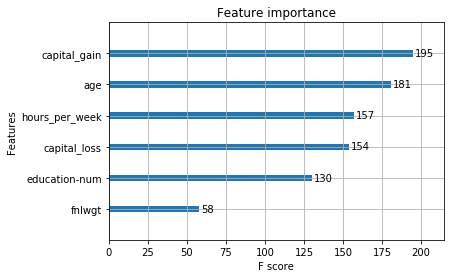

In [174]:
n_estimators = 50 

start=datetime.now()

lgb1 = LGBMClassifier(
 boosting_type='gbdt',
 num_leaves=30, 
 max_depth=5, 
 learning_rate=0.1, n_estimators=n_estimators, max_bin=255, 
 subsample_for_bin=0.8, objective=None, min_split_gain=0, 
 min_child_weight=5, min_child_samples=10, subsample=1, 
 subsample_freq=1, colsample_bytree=1, reg_alpha=1, reg_lambda=0, seed=410, nthread=7, silent=True)

#Fit the algorithm on the data
lgb_fit = lgb1.fit(features_train, label_train, eval_metric='auc')
        
#Predict training set:
dtrain_predictions = lgb1.predict(features_train)
dtrain_predprob = lgb1.predict_proba(features_train)[:,1]
#Print model report:
print("\nModel Report")
print("Accuracy : %.4g" % accuracy_score(label_train, dtrain_predictions))
print("AUC Score (Train): %f" % roc_auc_score(label_train, dtrain_predprob))
     
lgb_plot_importance(lgb_fit, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance', xlabel='F score', ylabel='Features', importance_type='split', max_num_features=7, grid=True,)
    
stop=datetime.now()
execution_time_lgbm = stop-start
print(execution_time_lgbm)  # 0:00:00.381134, much faster. Lower accuracy, maybe because of the param tuning is limited with cv()

In [10]:
def lgb_model_fit(alg, features_train, label_train):
    #Fit the algorithm on the data
    alg_fit = alg.fit(features_train, label_train, eval_metric='auc')

    #Predict training set:
    dtrain_predictions = alg.predict(features_train)
    dtrain_predprob = alg.predict_proba(features_train)[:,1]
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % accuracy_score(label_train, dtrain_predictions))
    print("AUC Score (Train): %f" % roc_auc_score(label_train, dtrain_predprob))

    lgb_plot_importance(alg_fit, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance', xlabel='F score', ylabel='Features', importance_type='split', max_num_features=7, grid=True,)

    return alg_fit

In [183]:
# LightGBM cross validation method 2 - GridSearchCV()
# the code here will be running forever

param_set = {
 'n_estimators':[20, 30, 40, 50, 60, 70]
}

gsearch = GridSearchCV(estimator = LGBMClassifier( boosting_type='gbdt', num_leaves=30, 
 max_depth=5, learning_rate=0.1, n_estimators=50, max_bin=225, # choose a small values for bins to speed up
 subsample_for_bin=5000, objective=None, min_split_gain=0, min_child_weight=5, 
 min_child_samples=10, subsample=1, subsample_freq=1, colsample_bytree=1, 
 reg_alpha=1, reg_lambda=0, seed=410, nthread=7, silent=True), 
 param_grid = param_set, scoring='roc_auc',n_jobs=1,iid=False, cv=10)

lgb_model2 = gsearch.fit(features_train, label_train)
lgb_model2.grid_scores_, lgb_model2.best_params_, lgb_model2.best_score_

([mean: 0.85892, std: 0.00829, params: {'n_estimators': 20},
  mean: 0.86448, std: 0.00804, params: {'n_estimators': 30},
  mean: 0.86828, std: 0.00789, params: {'n_estimators': 40},
  mean: 0.87092, std: 0.00725, params: {'n_estimators': 50},
  mean: 0.87237, std: 0.00714, params: {'n_estimators': 60},
  mean: 0.87354, std: 0.00721, params: {'n_estimators': 70}],
 {'n_estimators': 70},
 0.8735423039713573)

In [182]:
param_set = {
 'n_estimators':[70, 100, 500, 1000]
}

gsearch = GridSearchCV(estimator = LGBMClassifier( boosting_type='gbdt', num_leaves=30, 
 max_depth=5, learning_rate=0.1, n_estimators=50, max_bin=225, # choose a small values for bins to speed up
 subsample_for_bin=5000, objective=None, min_split_gain=0, min_child_weight=5, 
 min_child_samples=10, subsample=1, subsample_freq=1, colsample_bytree=1, 
 reg_alpha=1, reg_lambda=0, seed=410, nthread=7, silent=True), 
 param_grid = param_set, scoring='roc_auc',n_jobs=1,iid=False, cv=10)

lgb_model2 = gsearch.fit(features_train, label_train)
lgb_model2.grid_scores_, lgb_model2.best_params_, lgb_model2.best_score_

([mean: 0.87354, std: 0.00721, params: {'n_estimators': 70},
  mean: 0.87516, std: 0.00699, params: {'n_estimators': 100},
  mean: 0.87364, std: 0.00720, params: {'n_estimators': 500},
  mean: 0.86703, std: 0.00729, params: {'n_estimators': 1000}],
 {'n_estimators': 100},
 0.8751582381381662)

In [185]:
param_set = {
 'max_depth':[5,7,9,11,13,15]
}

gsearch = GridSearchCV(estimator = LGBMClassifier( boosting_type='gbdt', num_leaves=30, 
 max_depth=5, learning_rate=0.1, n_estimators=100, max_bin=225,
 subsample_for_bin=5000, objective=None, min_split_gain=0, min_child_weight=5, 
 min_child_samples=10, subsample=1, subsample_freq=1, colsample_bytree=1, 
 reg_alpha=1, reg_lambda=0, seed=410, nthread=7, silent=True), 
 param_grid = param_set, scoring='roc_auc',n_jobs=1,iid=False, cv=10)

lgb_model2 = gsearch.fit(features_train, label_train)
lgb_model2.grid_scores_, lgb_model2.best_params_, lgb_model2.best_score_

([mean: 0.87516, std: 0.00699, params: {'max_depth': 5},
  mean: 0.87438, std: 0.00711, params: {'max_depth': 7},
  mean: 0.87445, std: 0.00713, params: {'max_depth': 9},
  mean: 0.87347, std: 0.00713, params: {'max_depth': 11},
  mean: 0.87316, std: 0.00696, params: {'max_depth': 13},
  mean: 0.87306, std: 0.00728, params: {'max_depth': 15}],
 {'max_depth': 5},
 0.8751582381381662)

In [186]:
param_set = {
 'max_depth':[1,2,3,4,5]
}

gsearch = GridSearchCV(estimator = LGBMClassifier( boosting_type='gbdt', num_leaves=30, 
 max_depth=5, learning_rate=0.1, n_estimators=100, max_bin=225,
 subsample_for_bin=5000, objective=None, min_split_gain=0, min_child_weight=5, 
 min_child_samples=10, subsample=1, subsample_freq=1, colsample_bytree=1, 
 reg_alpha=1, reg_lambda=0, seed=410, nthread=7, silent=True), 
 param_grid = param_set, scoring='roc_auc',n_jobs=1,iid=False, cv=10)

lgb_model2 = gsearch.fit(features_train, label_train)
lgb_model2.grid_scores_, lgb_model2.best_params_, lgb_model2.best_score_

([mean: 0.85743, std: 0.00786, params: {'max_depth': 1},
  mean: 0.86739, std: 0.00779, params: {'max_depth': 2},
  mean: 0.87217, std: 0.00725, params: {'max_depth': 3},
  mean: 0.87448, std: 0.00670, params: {'max_depth': 4},
  mean: 0.87516, std: 0.00699, params: {'max_depth': 5}],
 {'max_depth': 5},
 0.8751582381381662)

In [187]:
param_set = {
 'num_leaves':[20, 25, 30, 35] # this value often starts with 2^max_depth
}    
    
gsearch = GridSearchCV(estimator = LGBMClassifier( boosting_type='gbdt', num_leaves=30, 
 max_depth=5, learning_rate=0.1, n_estimators=100, max_bin=225,
 subsample_for_bin=5000, objective=None, min_split_gain=0, min_child_weight=5, 
 min_child_samples=10, subsample=1, subsample_freq=1, colsample_bytree=1, 
 reg_alpha=1, reg_lambda=0, seed=410, nthread=7, silent=True), 
 param_grid = param_set, scoring='roc_auc',n_jobs=1,iid=False, cv=10)

lgb_model2 = gsearch.fit(features_train, label_train)
lgb_model2.grid_scores_, lgb_model2.best_params_, lgb_model2.best_score_

([mean: 0.87502, std: 0.00698, params: {'num_leaves': 20},
  mean: 0.87523, std: 0.00699, params: {'num_leaves': 25},
  mean: 0.87516, std: 0.00699, params: {'num_leaves': 30},
  mean: 0.87516, std: 0.00699, params: {'num_leaves': 35}],
 {'num_leaves': 25},
 0.8752295970057501)

In [188]:
param_set = {
 'min_child_samples':[10, 50, 100, 100] # this depends on num_leaves the number of data records. 
    # large value to avoid overfitting, but may lead to underfitting
}    
    
gsearch = GridSearchCV(estimator = LGBMClassifier( boosting_type='gbdt', num_leaves=30, 
 max_depth=5, learning_rate=0.1, n_estimators=100, max_bin=225,
 subsample_for_bin=5000, objective=None, min_split_gain=0, min_child_weight=5, 
 min_child_samples=10, subsample=1, subsample_freq=1, colsample_bytree=1, 
 reg_alpha=1, reg_lambda=0, seed=410, nthread=7, silent=True), 
 param_grid = param_set, scoring='roc_auc',n_jobs=1,iid=False, cv=10)

lgb_model2 = gsearch.fit(features_train, label_train)
lgb_model2.grid_scores_, lgb_model2.best_params_, lgb_model2.best_score_

([mean: 0.87516, std: 0.00699, params: {'min_child_samples': 10},
  mean: 0.87376, std: 0.00697, params: {'min_child_samples': 50},
  mean: 0.87151, std: 0.00712, params: {'min_child_samples': 100},
  mean: 0.87151, std: 0.00712, params: {'min_child_samples': 100}],
 {'min_child_samples': 10},
 0.8751582381381662)

In [189]:
param_set = {
 'min_child_samples':[1, 3, 5, 7, 9, 10] # this depends on num_leaves the number of data records. 
    # large value to avoid overfitting, but may lead to underfitting
}    
    
gsearch = GridSearchCV(estimator = LGBMClassifier( boosting_type='gbdt', num_leaves=30, 
 max_depth=5, learning_rate=0.1, n_estimators=100, max_bin=225,
 subsample_for_bin=5000, objective=None, min_split_gain=0, min_child_weight=5, 
 min_child_samples=10, subsample=1, subsample_freq=1, colsample_bytree=1, 
 reg_alpha=1, reg_lambda=0, seed=410, nthread=7, silent=True), 
 param_grid = param_set, scoring='roc_auc',n_jobs=1,iid=False, cv=10)

lgb_model2 = gsearch.fit(features_train, label_train)
lgb_model2.grid_scores_, lgb_model2.best_params_, lgb_model2.best_score_

# in fact here, mean, std didn't change

([mean: 0.87516, std: 0.00699, params: {'min_child_samples': 1},
  mean: 0.87516, std: 0.00699, params: {'min_child_samples': 3},
  mean: 0.87516, std: 0.00699, params: {'min_child_samples': 5},
  mean: 0.87516, std: 0.00699, params: {'min_child_samples': 7},
  mean: 0.87516, std: 0.00699, params: {'min_child_samples': 9},
  mean: 0.87516, std: 0.00699, params: {'min_child_samples': 10}],
 {'min_child_samples': 1},
 0.8751582381381662)

In [190]:
param_set = {
 'min_child_samples':[10, 11, 12, 13, 14, 15] # this depends on num_leaves the number of data records. 
    # large value to avoid overfitting, but may lead to underfitting
}    
    
gsearch = GridSearchCV(estimator = LGBMClassifier(boosting_type='gbdt', num_leaves=30, 
 max_depth=5, learning_rate=0.1, n_estimators=100, max_bin=225,
 subsample_for_bin=5000, objective=None, min_split_gain=0, min_child_weight=5, 
 min_child_samples=10, subsample=1, subsample_freq=1, colsample_bytree=1, 
 reg_alpha=1, reg_lambda=0, seed=410, nthread=7, silent=True), 
 param_grid = param_set, scoring='roc_auc',n_jobs=1,iid=False, cv=10)

lgb_model2 = gsearch.fit(features_train, label_train)
lgb_model2.grid_scores_, lgb_model2.best_params_, lgb_model2.best_score_

([mean: 0.87516, std: 0.00699, params: {'min_child_samples': 10},
  mean: 0.87516, std: 0.00699, params: {'min_child_samples': 11},
  mean: 0.87516, std: 0.00699, params: {'min_child_samples': 12},
  mean: 0.87516, std: 0.00699, params: {'min_child_samples': 13},
  mean: 0.87516, std: 0.00699, params: {'min_child_samples': 14},
  mean: 0.87516, std: 0.00699, params: {'min_child_samples': 15}],
 {'min_child_samples': 10},
 0.8751582381381662)


Model Report
Accuracy : 0.846
AUC Score (Train): 0.885370
0:00:00.635665
[0 0 0 ..., 0 1 0]


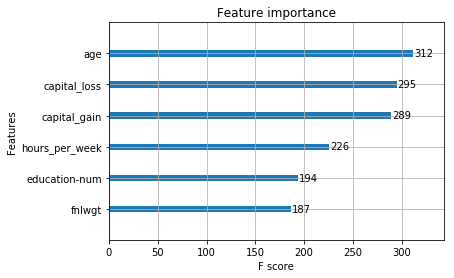

In [193]:
start=datetime.now()

lgb2 = LGBMClassifier(
 boosting_type='gbdt', 
 num_leaves=30, 
 max_depth=5, 
 learning_rate=0.1, 
 n_estimators=100, 
 max_bin=225,
 subsample_for_bin=5000,
 min_split_gain=0, 
 min_child_weight=5, 
 min_child_samples=10, 
 subsample=1, subsample_freq=1, colsample_bytree=1, 
 reg_alpha=1, reg_lambda=0, seed=410, nthread=7
)

lgb_model2 = lgb_model_fit(lgb2, features_train, label_train)

stop=datetime.now()
execution_time_lgbm = stop-start
print(execution_time_lgbm)        # 0:00:00.635665

ypred = lgb_model2.predict(features_test) 
print(ypred)

In [195]:
ypred2=lgb_model2.predict(features_test)

cm = confusion_matrix(label_test, ypred2)
TP = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TN = cm[1][1]

accuracy_lgb = (TP + TN)/(TP+FP+FN+TN)   
auc_score_lgb = roc_auc_score(label_test, ypred)   
precision_lgb = TP/(TP+FP)   
specificity_lgb = TN/(TN+FP)  
recall_lgb = TP/(TP+FN)   
print("accuracy: ", accuracy_lgb)
print("AUC: ", auc_score_lgb)
print("Precision: ", precision_lgb)
print("Specificity: ", specificity_lgb)
print("Recall: ", recall_lgb)

accuracy:  0.848705087522
AUC:  0.720628320665
Precision:  0.961379126019
Specificity:  0.791486291486
Recall:  0.858165334606


In [196]:
param_set = {
 'max_bin':[50, 100, 200, 225, 300, 500, 1000],
 'subsample_for_bin':[100, 500, 1000, 5000, 10000]
}    
    
gsearch = GridSearchCV(estimator = LGBMClassifier(boosting_type='gbdt', num_leaves=30, 
 max_depth=5, learning_rate=0.1, n_estimators=100, max_bin=225,
 subsample_for_bin=5000, min_split_gain=0, min_child_weight=5, 
 min_child_samples=10, subsample=1, subsample_freq=1, colsample_bytree=1, 
 reg_alpha=1, reg_lambda=0, seed=410, nthread=7, silent=True), 
 param_grid = param_set, scoring='roc_auc',n_jobs=1,iid=False, cv=10)

lgb_model3 = gsearch.fit(features_train, label_train)
lgb_model3.grid_scores_, lgb_model3.best_params_, lgb_model3.best_score_

([mean: 0.87539, std: 0.00713, params: {'max_bin': 50, 'subsample_for_bin': 100},
  mean: 0.87539, std: 0.00713, params: {'max_bin': 50, 'subsample_for_bin': 500},
  mean: 0.87539, std: 0.00713, params: {'max_bin': 50, 'subsample_for_bin': 1000},
  mean: 0.87539, std: 0.00713, params: {'max_bin': 50, 'subsample_for_bin': 5000},
  mean: 0.87539, std: 0.00713, params: {'max_bin': 50, 'subsample_for_bin': 10000},
  mean: 0.87537, std: 0.00709, params: {'max_bin': 100, 'subsample_for_bin': 100},
  mean: 0.87537, std: 0.00709, params: {'max_bin': 100, 'subsample_for_bin': 500},
  mean: 0.87537, std: 0.00709, params: {'max_bin': 100, 'subsample_for_bin': 1000},
  mean: 0.87537, std: 0.00709, params: {'max_bin': 100, 'subsample_for_bin': 5000},
  mean: 0.87537, std: 0.00709, params: {'max_bin': 100, 'subsample_for_bin': 10000},
  mean: 0.87495, std: 0.00723, params: {'max_bin': 200, 'subsample_for_bin': 100},
  mean: 0.87495, std: 0.00723, params: {'max_bin': 200, 'subsample_for_bin': 500},
 

In [197]:
param_set = {
 'max_bin':[10, 20, 30, 40, 50],
 'subsample_for_bin':[20, 40, 60, 80, 100]
}    
    
gsearch = GridSearchCV(estimator = LGBMClassifier(boosting_type='gbdt', num_leaves=30, 
 max_depth=5, learning_rate=0.1, n_estimators=100, max_bin=225,
 subsample_for_bin=5000, min_split_gain=0, min_child_weight=5, 
 min_child_samples=10, subsample=1, subsample_freq=1, colsample_bytree=1, 
 reg_alpha=1, reg_lambda=0, seed=410, nthread=7, silent=True), 
 param_grid = param_set, scoring='roc_auc',n_jobs=1,iid=False, cv=10)

lgb_model3 = gsearch.fit(features_train, label_train)
lgb_model3.grid_scores_, lgb_model3.best_params_, lgb_model3.best_score_

([mean: 0.86329, std: 0.00706, params: {'max_bin': 10, 'subsample_for_bin': 20},
  mean: 0.86329, std: 0.00706, params: {'max_bin': 10, 'subsample_for_bin': 40},
  mean: 0.86329, std: 0.00706, params: {'max_bin': 10, 'subsample_for_bin': 60},
  mean: 0.86329, std: 0.00706, params: {'max_bin': 10, 'subsample_for_bin': 80},
  mean: 0.86329, std: 0.00706, params: {'max_bin': 10, 'subsample_for_bin': 100},
  mean: 0.86834, std: 0.00695, params: {'max_bin': 20, 'subsample_for_bin': 20},
  mean: 0.86834, std: 0.00695, params: {'max_bin': 20, 'subsample_for_bin': 40},
  mean: 0.86834, std: 0.00695, params: {'max_bin': 20, 'subsample_for_bin': 60},
  mean: 0.86834, std: 0.00695, params: {'max_bin': 20, 'subsample_for_bin': 80},
  mean: 0.86834, std: 0.00695, params: {'max_bin': 20, 'subsample_for_bin': 100},
  mean: 0.87431, std: 0.00676, params: {'max_bin': 30, 'subsample_for_bin': 20},
  mean: 0.87431, std: 0.00676, params: {'max_bin': 30, 'subsample_for_bin': 40},
  mean: 0.87431, std: 0.00


Model Report
Accuracy : 0.8455
AUC Score (Train): 0.885088
0:00:00.622074
[0 0 0 ..., 0 1 0]


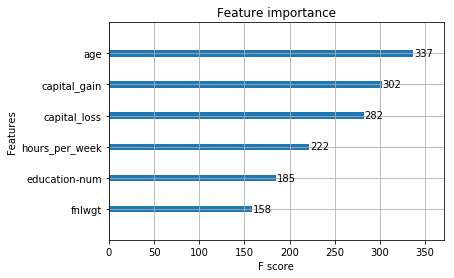

In [199]:
start=datetime.now()

lgb3 = LGBMClassifier(
 boosting_type='gbdt', 
 num_leaves=30, 
 max_depth=5, 
 learning_rate=0.1, 
 n_estimators=100, 
 max_bin=50,
 subsample_for_bin=20,
 min_split_gain=0, 
 min_child_weight=5, 
 min_child_samples=10, 
 subsample=1, subsample_freq=1, colsample_bytree=1, 
 reg_alpha=1, reg_lambda=0, seed=410, nthread=7
)

lgb_model3 = lgb_model_fit(lgb3, features_train, label_train)

stop=datetime.now()
execution_time_lgbm = stop-start
print(execution_time_lgbm)        # 0:00:00.622074

ypred = lgb_model3.predict(features_test) 
print(ypred)

In [201]:
ypred3=lgb_model3.predict(features_test)

cm = confusion_matrix(label_test, ypred3)
TP = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TN = cm[1][1]

accuracy_lgb = (TP + TN)/(TP+FP+FN+TN)   
auc_score_lgb = roc_auc_score(label_test, ypred)   
precision_lgb = TP/(TP+FP)   
specificity_lgb = TN/(TN+FP)  
recall_lgb = TP/(TP+FN)   
print("accuracy: ", accuracy_lgb)
print("AUC: ", auc_score_lgb)
print("Precision: ", precision_lgb)
print("Specificity: ", specificity_lgb)
print("Recall: ", recall_lgb)

# the results here didn't really improve, maybe because of overfitting

accuracy:  0.847988535162
AUC:  0.719704880201
Precision:  0.96084458105
Specificity:  0.788752703677
Recall:  0.85779050346



Model Report
Accuracy : 0.8777
AUC Score (Train): 0.935886
0:00:00.835169
[1 0 0 ..., 0 1 0]


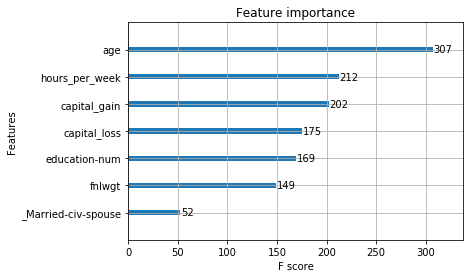

In [14]:
start=datetime.now()

lgb3 = LGBMClassifier(
 boosting_type='gbdt', 
 num_leaves=30, 
 max_depth=5, 
 learning_rate=0.1, 
 n_estimators=100, 
 max_bin=50,
 subsample_for_bin=5000,
 min_split_gain=0, 
 min_child_weight=5, 
 min_child_samples=10, 
 subsample=1, subsample_freq=1, colsample_bytree=1, 
 reg_alpha=1, reg_lambda=0, seed=410, nthread=7
)

lgb_model3 = lgb_model_fit(lgb3, features_train, label_train)

stop=datetime.now()
execution_time_lgbm = stop-start
print(execution_time_lgbm)        # 0:00:00.622074

ypred = lgb_model3.predict(features_test) 
print(ypred)

In [15]:
ypred3=lgb_model3.predict(features_test)

cm = confusion_matrix(label_test, ypred3)
TP = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TN = cm[1][1]

accuracy_lgb = (TP + TN)/(TP+FP+FN+TN)   
auc_score_lgb = roc_auc_score(label_test, ypred)   
precision_lgb = TP/(TP+FP)   
specificity_lgb = TN/(TN+FP)  
recall_lgb = TP/(TP+FN)   
print("accuracy: ", accuracy_lgb)
print("AUC: ", auc_score_lgb)
print("Precision: ", precision_lgb)
print("Specificity: ", specificity_lgb)
print("Recall: ", recall_lgb)

accuracy:  0.870406387552
AUC:  0.786565544728
Precision:  0.947382586462
Specificity:  0.789104638619
Recall:  0.889450410613


In [16]:
param_set = {
 'min_child_weight':[3, 5, 7, 9],
 'colsample_bytree':[0.2, 0.4, 0.6, 0.8, 1],
 'subsample':[0.2, 0.4, 0.6, 0.8, 1]
}    
    
gsearch = GridSearchCV(estimator = LGBMClassifier(boosting_type='gbdt', num_leaves=30, 
 max_depth=5, learning_rate=0.1, n_estimators=100, max_bin=50,
 subsample_for_bin=5000, min_split_gain=0, min_child_weight=5, 
 min_child_samples=10, subsample=1, subsample_freq=1, colsample_bytree=1, 
 reg_alpha=1, reg_lambda=0, seed=410, nthread=7), 
 param_grid = param_set, scoring='roc_auc',n_jobs=1,iid=False, cv=10)

lgb_model4 = gsearch.fit(features_train, label_train)
lgb_model4.grid_scores_, lgb_model4.best_params_, lgb_model4.best_score_

([mean: 0.91795, std: 0.00419, params: {'colsample_bytree': 0.2, 'min_child_weight': 3, 'subsample': 0.2},
  mean: 0.92079, std: 0.00417, params: {'colsample_bytree': 0.2, 'min_child_weight': 3, 'subsample': 0.4},
  mean: 0.92196, std: 0.00429, params: {'colsample_bytree': 0.2, 'min_child_weight': 3, 'subsample': 0.6},
  mean: 0.92262, std: 0.00427, params: {'colsample_bytree': 0.2, 'min_child_weight': 3, 'subsample': 0.8},
  mean: 0.92315, std: 0.00449, params: {'colsample_bytree': 0.2, 'min_child_weight': 3, 'subsample': 1},
  mean: 0.91624, std: 0.00422, params: {'colsample_bytree': 0.2, 'min_child_weight': 5, 'subsample': 0.2},
  mean: 0.91949, std: 0.00443, params: {'colsample_bytree': 0.2, 'min_child_weight': 5, 'subsample': 0.4},
  mean: 0.92113, std: 0.00423, params: {'colsample_bytree': 0.2, 'min_child_weight': 5, 'subsample': 0.6},
  mean: 0.92187, std: 0.00428, params: {'colsample_bytree': 0.2, 'min_child_weight': 5, 'subsample': 0.8},
  mean: 0.92222, std: 0.00430, params: 

In [19]:
param_set = {
 'min_child_weight':[1,2,3,4]
}    
    
gsearch = GridSearchCV(estimator = LGBMClassifier(boosting_type='gbdt', num_leaves=30, 
 max_depth=5, learning_rate=0.1, n_estimators=100, max_bin=50,
 subsample_for_bin=5000, min_split_gain=0, min_child_weight=5, 
 min_child_samples=10, subsample=1, subsample_freq=1, colsample_bytree=1, 
 reg_alpha=1, reg_lambda=0, seed=410, nthread=7), 
 param_grid = param_set, scoring='roc_auc',n_jobs=1,iid=False, cv=10)

lgb_model4 = gsearch.fit(features_train, label_train)
lgb_model4.grid_scores_, lgb_model4.best_params_, lgb_model4.best_score_

([mean: 0.92680, std: 0.00506, params: {'min_child_weight': 1},
  mean: 0.92686, std: 0.00489, params: {'min_child_weight': 2},
  mean: 0.92649, std: 0.00518, params: {'min_child_weight': 3},
  mean: 0.92628, std: 0.00488, params: {'min_child_weight': 4}],
 {'min_child_weight': 2},
 0.9268573610867094)


Model Report
Accuracy : 0.8771
AUC Score (Train): 0.935860
0:00:00.881916
[1 0 0 ..., 0 1 0]


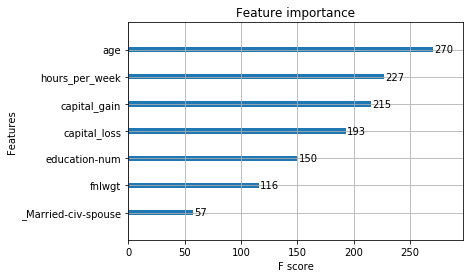

In [22]:
start=datetime.now()

lgb4 = LGBMClassifier(
 boosting_type='gbdt', 
 num_leaves=30, 
 max_depth=5, 
 learning_rate=0.1, 
 n_estimators=100, 
 max_bin=50,
 subsample_for_bin=5000,
 min_split_gain=0, 
 min_child_weight=3, 
 min_child_samples=10, 
 subsample=1, subsample_freq=1, colsample_bytree=0.6, 
 reg_alpha=1, reg_lambda=0, seed=410, nthread=7
)

lgb_model4 = lgb_model_fit(lgb4, features_train, label_train)

stop=datetime.now()
execution_time_lgbm = stop-start
print(execution_time_lgbm)        # 0:00:00.622074

ypred = lgb_model4.predict(features_test) 
print(ypred)

In [23]:
ypred4=lgb_model4.predict(features_test)

cm = confusion_matrix(label_test, ypred4)
TP = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TN = cm[1][1]

accuracy_lgb = (TP + TN)/(TP+FP+FN+TN)   
auc_score_lgb = roc_auc_score(label_test, ypred)   
precision_lgb = TP/(TP+FP)   
specificity_lgb = TN/(TN+FP)  
recall_lgb = TP/(TP+FN)   
print("accuracy: ", accuracy_lgb)
print("AUC: ", auc_score_lgb)
print("Precision: ", precision_lgb)
print("Specificity: ", specificity_lgb)
print("Recall: ", recall_lgb)

accuracy:  0.87143003378
AUC:  0.787238401679
Precision:  0.948728300363
Specificity:  0.793383947939
Recall:  0.889589905363



Model Report
Accuracy : 0.8782
AUC Score (Train): 0.936438
0:00:00.886732
[1 0 0 ..., 0 1 0]


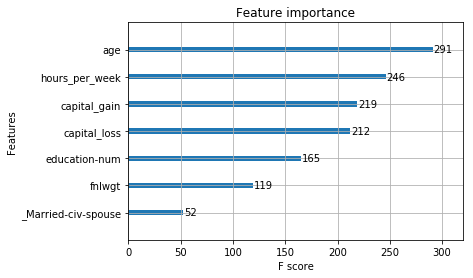

In [24]:
start=datetime.now()

lgb4 = LGBMClassifier(
 boosting_type='gbdt', 
 num_leaves=30, 
 max_depth=5, 
 learning_rate=0.1, 
 n_estimators=100, 
 max_bin=50,
 subsample_for_bin=5000,
 min_split_gain=0, 
 min_child_weight=2, 
 min_child_samples=10, 
 subsample=1, subsample_freq=1, colsample_bytree=0.6, 
 reg_alpha=1, reg_lambda=0, seed=410, nthread=7
)

lgb_model4 = lgb_model_fit(lgb4, features_train, label_train)

stop=datetime.now()
execution_time_lgbm = stop-start
print(execution_time_lgbm)        # 0:00:00.886732

ypred = lgb_model4.predict(features_test) 
print(ypred)

In [25]:
ypred4=lgb_model4.predict(features_test)

cm = confusion_matrix(label_test, ypred4)
TP = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TN = cm[1][1]

accuracy_lgb = (TP + TN)/(TP+FP+FN+TN)   
auc_score_lgb = roc_auc_score(label_test, ypred)   
precision_lgb = TP/(TP+FP)   
specificity_lgb = TN/(TN+FP)  
recall_lgb = TP/(TP+FN)   
print("accuracy: ", accuracy_lgb)
print("AUC: ", auc_score_lgb)
print("Precision: ", precision_lgb)
print("Specificity: ", specificity_lgb)
print("Recall: ", recall_lgb)

# overfit

accuracy:  0.871122939912
AUC:  0.787036544593
Precision:  0.948324586193
Specificity:  0.792095289659
Recall:  0.889548093916


In [26]:
param_set = {
 'learning_rate':[0.01, 0.05, 0.1, 0.2]
}    
    
gsearch = GridSearchCV(estimator = LGBMClassifier(boosting_type='gbdt', num_leaves=30, 
 max_depth=5, learning_rate=0.1, n_estimators=100, max_bin=50,
 subsample_for_bin=5000, min_split_gain=0, min_child_weight=3, 
 min_child_samples=10, subsample=1, subsample_freq=1, colsample_bytree=0.6, 
 reg_alpha=1, reg_lambda=0, seed=410, nthread=7), 
 param_grid = param_set, scoring='roc_auc',n_jobs=1,iid=False, cv=10)

lgb_model5 = gsearch.fit(features_train, label_train)
lgb_model5.grid_scores_, lgb_model5.best_params_, lgb_model5.best_score_

([mean: 0.91058, std: 0.00572, params: {'learning_rate': 0.01},
  mean: 0.92155, std: 0.00528, params: {'learning_rate': 0.05},
  mean: 0.92691, std: 0.00472, params: {'learning_rate': 0.1},
  mean: 0.92854, std: 0.00452, params: {'learning_rate': 0.2}],
 {'learning_rate': 0.2},
 0.9285375090265123)

In [27]:
param_set = {
 'learning_rate':[0.2, 0.3, 0.4, 0.5]
}    
    
gsearch = GridSearchCV(estimator = LGBMClassifier(boosting_type='gbdt', num_leaves=30, 
 max_depth=5, learning_rate=0.1, n_estimators=100, max_bin=50,
 subsample_for_bin=5000, min_split_gain=0, min_child_weight=3, 
 min_child_samples=10, subsample=1, subsample_freq=1, colsample_bytree=0.6, 
 reg_alpha=1, reg_lambda=0, seed=410, nthread=7), 
 param_grid = param_set, scoring='roc_auc',n_jobs=1,iid=False, cv=10)

lgb_model5 = gsearch.fit(features_train, label_train)
lgb_model5.grid_scores_, lgb_model5.best_params_, lgb_model5.best_score_

([mean: 0.92854, std: 0.00452, params: {'learning_rate': 0.2},
  mean: 0.92729, std: 0.00488, params: {'learning_rate': 0.3},
  mean: 0.92626, std: 0.00466, params: {'learning_rate': 0.4},
  mean: 0.92397, std: 0.00423, params: {'learning_rate': 0.5}],
 {'learning_rate': 0.2},
 0.9285375090265123)


Model Report
Accuracy : 0.8854
AUC Score (Train): 0.943116
0:00:00.843361
[1 0 0 ..., 0 1 0]


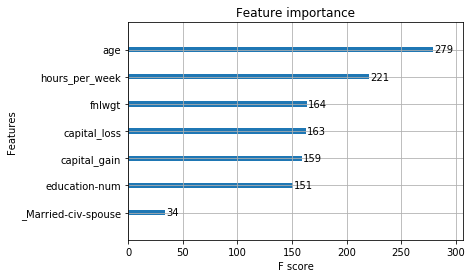

In [28]:
start=datetime.now()

lgb5 = LGBMClassifier(
 boosting_type='gbdt', 
 num_leaves=30, 
 max_depth=5, 
 learning_rate=0.2, 
 n_estimators=100, 
 max_bin=50,
 subsample_for_bin=5000,
 min_split_gain=0, 
 min_child_weight=3, 
 min_child_samples=10, 
 subsample=1, subsample_freq=1, colsample_bytree=0.6, 
 reg_alpha=1, reg_lambda=0, seed=410, nthread=7
)

lgb_model5 = lgb_model_fit(lgb5, features_train, label_train)

stop=datetime.now()
execution_time_lgbm = stop-start
print(execution_time_lgbm)        # 0:00:00.843361

ypred = lgb_model5.predict(features_test) 
print(ypred)

In [29]:
ypred5=lgb_model5.predict(features_test)

cm = confusion_matrix(label_test, ypred5)
TP = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TN = cm[1][1]

accuracy_lgb = (TP + TN)/(TP+FP+FN+TN)   
auc_score_lgb = roc_auc_score(label_test, ypred)   
precision_lgb = TP/(TP+FP)   
specificity_lgb = TN/(TN+FP)  
recall_lgb = TP/(TP+FN)   
print("accuracy: ", accuracy_lgb)
print("AUC: ", auc_score_lgb)
print("Precision: ", precision_lgb)
print("Specificity: ", specificity_lgb)
print("Recall: ", recall_lgb)

accuracy:  0.87143003378
AUC:  0.79456701684
Precision:  0.941999730857
Specificity:  0.77829218107
Recall:  0.894568690096



Model Report
Accuracy : 0.8874
AUC Score (Train): 0.943892
0:00:00.764053
[1 0 0 ..., 0 1 0]


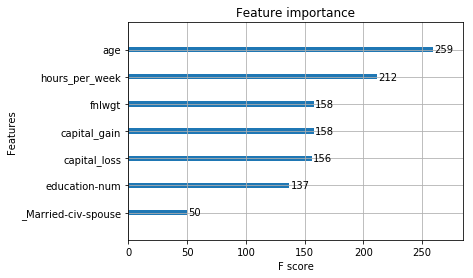

In [30]:
# try L2 regularization

start=datetime.now()

lgb6 = LGBMClassifier(
 boosting_type='gbdt', 
 num_leaves=30, 
 max_depth=5, 
 learning_rate=0.2, 
 n_estimators=100, 
 max_bin=50,
 subsample_for_bin=5000,
 min_split_gain=0, 
 min_child_weight=3, 
 min_child_samples=10, 
 subsample=1, subsample_freq=1, colsample_bytree=0.6, 
 reg_alpha=0, reg_lambda=1, seed=410, nthread=7
)

lgb_model6 = lgb_model_fit(lgb6, features_train, label_train)

stop=datetime.now()
execution_time_lgbm = stop-start
print(execution_time_lgbm)        # 0:00:00.764053

ypred = lgb_model6.predict(features_test) 
print(ypred)

In [31]:
ypred6=lgb_model6.predict(features_test)

cm = confusion_matrix(label_test, ypred6)
TP = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TN = cm[1][1]

accuracy_lgb = (TP + TN)/(TP+FP+FN+TN)   
auc_score_lgb = roc_auc_score(label_test, ypred)   
precision_lgb = TP/(TP+FP)   
specificity_lgb = TN/(TN+FP)  
recall_lgb = TP/(TP+FN)   
print("accuracy: ", accuracy_lgb)
print("AUC: ", auc_score_lgb)
print("Precision: ", precision_lgb)
print("Specificity: ", specificity_lgb)
print("Recall: ", recall_lgb)

# L1 works better in this case

accuracy:  0.87143003378
AUC:  0.79412729993
Precision:  0.942403445028
Specificity:  0.77915376677
Recall:  0.894266377219
